# Import

In [ ]:
from interpret import *
from tint.metrics import mse, mae
import tint, captum
from tqdm import tqdm
import pandas as pd
from utils.explainer import *
from exp.exp_interpret import *

# Arguments

In [97]:
parser = get_parser()
argv = """
  --explainers feature_permutation \
  --task_name classification \
  --data mimic \
  --use_gpu \
  --root_path ./dataset/mimic_iii/ \
  --data_path mimic_iii.pkl \
  --metrics auc 'accuracy' 'cross_entropy' \
  --model MICN --conv_kernel 24 24  
""".split()
args = parser.parse_args(argv)

# Disable cudnn if using cuda accelerator.
# Please see https://captum.ai/docs/faq#how-can-i-resolve-cudnn-rnn-backward-error-for-rnn-or-lstm-network
# args.use_gpu = False
initial_setup(args)

# Initialize

In [98]:
"Only long_term_forecast is supported for now"

if args.task_name == 'classification': Exp = Exp_Classification
else: Exp = Exp_Long_Term_Forecast
exp = Exp(args)  # set experiments
_, dataloader = exp._get_data(args.flag)
exp.load_best_model()

model = exp.model
_ = model.eval()
# model.zero_grad()

Use GPU: cuda:0
train 18390
test 2299
Experiments will be saved in ./results\mimic_iii_MICN
test 2299
Loading model from ./results\mimic_iii_MICN\checkpoint.pth


Model(
  (decomp_multi): series_decomp_multi()
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(31, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=128, bias=False)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (conv_trans): SeasonalPrediction(
    (mic): ModuleList(
      (0): MIC(
        (isometric_conv): ModuleList(
          (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
          (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
        )
        (conv): ModuleList(
          (0): Conv1d(128, 128, kernel_size=(24,), stride=(24,), padding=(12,))
          (1): Conv1d(128, 128, kernel_size=(24,), stride=(24,), padding=(12,))
        )
        (conv_trans): ModuleList(
          (0): ConvTranspose1d(128, 128, kernel_size=(24,), 

In [ ]:
explainers_map = dict()
for name in args.explainers:
    if name == 'augmented_occlusion':
        inputs = get_total_data(dataloader)
        explainers_map[name] = explainer_name_map[name](model, inputs)
    else:    
        explainers_map[name] = explainer_name_map[name](model)

# Evaluate

In [ ]:
results = []
baseline_mode = "random" # "zeros", "aug"
result_columns = ['batch_index', 'explainer', 'metric', 'area', 'comp', 'suff']

progress_bar = tqdm(
    enumerate(dataloader), total=len(dataloader), disable=False
)
for batch_index, (batch_x, batch_y, batch_x_mark, batch_y_mark) in progress_bar:
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float().to(exp.device)

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -exp.args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :exp.args.label_len, :], dec_inp], dim=1).float()
    # outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    
    inputs = (batch_x, batch_x_mark)
    # baseline must be a scaler or tuple of tensors with same dimension as input
    baselines = get_baseline(inputs, baseline_mode)
    additional_forward_args = (dec_inp, batch_y_mark)

    # get attributions
    for name in args.explainers:
        explainer = explainers_map[name]
        attr = compute_regressor_attr(
            inputs, baselines, explainer, additional_forward_args, args
        )
    
        # get scores
        for area in args.areas:
            for metric_name in ['mae', 'mse']:
                metric = getattr(tint.metrics, metric_name)
                error_comp = metric(
                    model, inputs=inputs, 
                    attributions=attr, baselines=baselines, 
                    additional_forward_args=additional_forward_args,
                    topk=area, mask_largest=True
                )
                
                error_suff = metric(
                    model, inputs=inputs, 
                    attributions=attr, baselines=baselines, 
                    additional_forward_args=additional_forward_args,
                    topk=area, mask_largest=False
                )
           
                result_row = [batch_index, name, metric_name, area, error_comp, error_suff]
                # print(result_row)
                results.append(result_row)

In [ ]:
results_df = pd.DataFrame(results, columns=result_columns)
results_df = results_df.groupby(['explainer', 'metric', 'area'])[['comp', 'suff']].aggregate('mean').reset_index()
# results_df.round(6).to_csv(os.path.join(result_folder, 'interpretation_results.csv'), index=False)
print(results_df)

# Others WIP

In [ ]:
if args.task_name == 'classification':
    batch_x, batch_y, padding_mask = next(iter(dataloader))
    batch_x = batch_x.float().to(exp.device)
    batch_y= batch_y.float().to(exp.device)
    padding_mask = padding_mask.float().to(exp.device)
    
    inputs = batch_x
    additional_forward_args = (padding_mask, None, None)
    baselines = get_baseline(inputs)
    
else:
    batch_x, batch_y, batch_x_mark, batch_y_mark = next(iter(dataloader))
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float().to(exp.device)

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -exp.args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :exp.args.label_len, :], dec_inp], dim=1).float()
    
    inputs = (batch_x, batch_x_mark)
    additional_forward_args = (dec_inp, batch_y_mark)
    baselines = get_baseline(inputs)

In [ ]:
def normalize_feature(attr):
    temp = attr - attr.min(axis=(2, 3),keepdims=True)
    temp2 = temp.sum(axis=(2, 3), keepdims=True)
    return temp * 100 / temp2 

In [100]:
explainer = FeatureAblation(model)
attr = compute_classifier_attr(
    inputs, baselines, explainer, additional_forward_args,
    args, avg_attr=False
)

attr_numpy = attr.detach().cpu().numpy()
attr_numpy_normed = normalize_feature(attr_numpy)

## TSR

In [101]:
tsr_explainer = TSRTunnel(FeatureAblation(model))
tsr_attr = compute_classifier_tsr_attr(
    args, explainer, inputs=inputs, 
    sliding_window_shapes=(1,1), 
    strides=1, baselines=baselines,
    additional_forward_args=additional_forward_args,
    avg_attr=False
)

tsr_attr_numpy = tsr_attr.detach().cpu().numpy()
tsr_attr_normed  = normalize_feature(tsr_attr_numpy)

In [163]:
attr_list = []
tsr_attr_list = []

for batch_index, (batch_x, batch_y, padding_mask) in enumerate(dataloader):
    batch_x = batch_x.float().to(exp.device)
    batch_y= batch_y.float().to(exp.device)
    padding_mask = padding_mask.float().to(exp.device)
    
    inputs = batch_x
    additional_forward_args = (padding_mask, None, None)
    baselines = get_baseline(inputs)
    
    attr = compute_classifier_attr(
        inputs, baselines, explainer, additional_forward_args,
        args, avg_attr=False
    )
    attr_list.append(attr)

    tsr_attr = compute_classifier_tsr_attr(
        args, explainer, inputs=inputs, 
        sliding_window_shapes=(1,1), 
        strides=1, baselines=baselines,
        additional_forward_args=additional_forward_args,
        avg_attr=False
    )
    tsr_attr_list.append(tsr_attr)
    if batch_index == 5:
        break

In [166]:
attr = torch.vstack(attr_list)
tsr_attr = torch.vstack(tsr_attr_list)

attr_numpy = attr.detach().cpu().numpy()
tsr_attr_numpy = tsr_attr.detach().cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
from exp.plot_config import *
%matplotlib inline

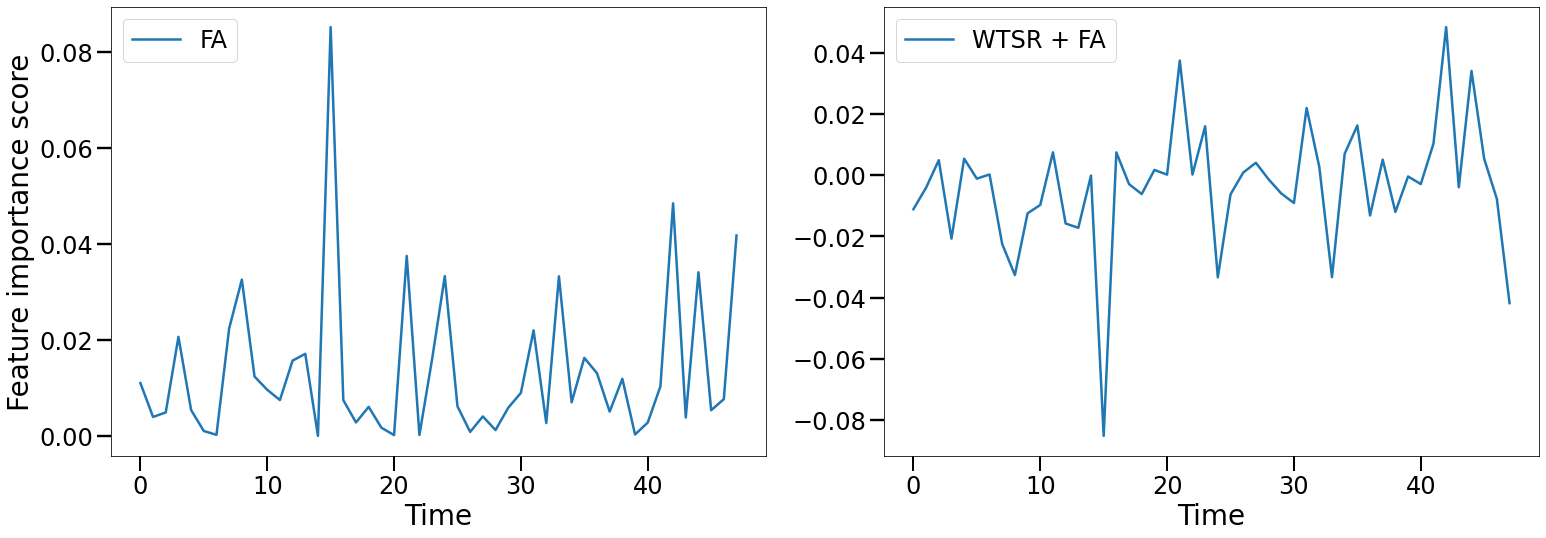

In [222]:
example_no = 1
output = 1

fig, axes = plt.subplots(1, 2, figsize=(22, 8))
dist1 = attr_numpy[example_no, output, :, 20]
dist2 = tsr_attr_numpy[example_no, output, :, 20]

axes[0].plot(attr_numpy[example_no, 1, :, 1], label='FA')
axes[0].legend()
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Feature importance score')

axes[1].plot(tsr_attr_numpy[example_no, 1, :, 1], label='WTSR + FA')
axes[1].legend()
axes[1].set_xlabel('Time')
    
fig.tight_layout()
plt.savefig('results/single_example.jpg', dpi=200)
plt.show()

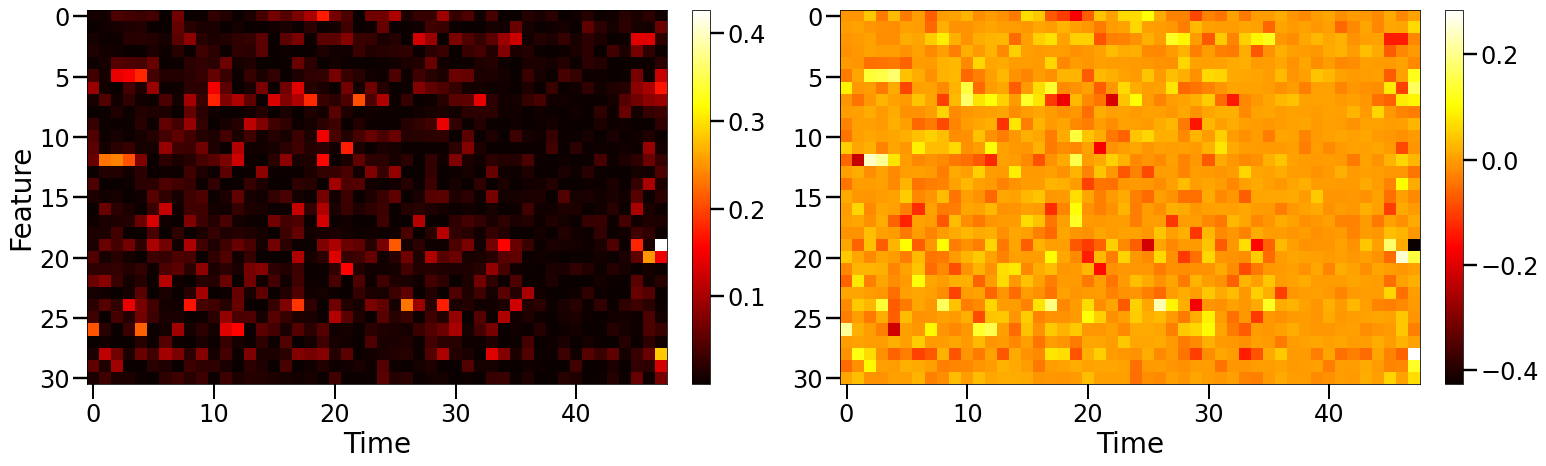

In [210]:
example_no = 1
output = 0

fig, axes = plt.subplots(1, 2, figsize =(22, 7))

im = axes[0].imshow(attr_numpy[example_no, output].T, cmap='hot', interpolation='nearest')
axes[0].figure.colorbar(im, fraction=0.03, pad=0.04)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Feature')
# plt.show()
im = axes[1].imshow(tsr_attr_numpy[example_no, output].T, cmap='hot', interpolation='nearest')
axes[1].figure.colorbar(im, fraction=0.03, pad=0.04)
axes[1].set_xlabel('Time')

fig.tight_layout()
plt.suptitle('Heat map of feature importance scores')
plt.savefig('results/heatmap.jpg', dpi=200)
plt.show()

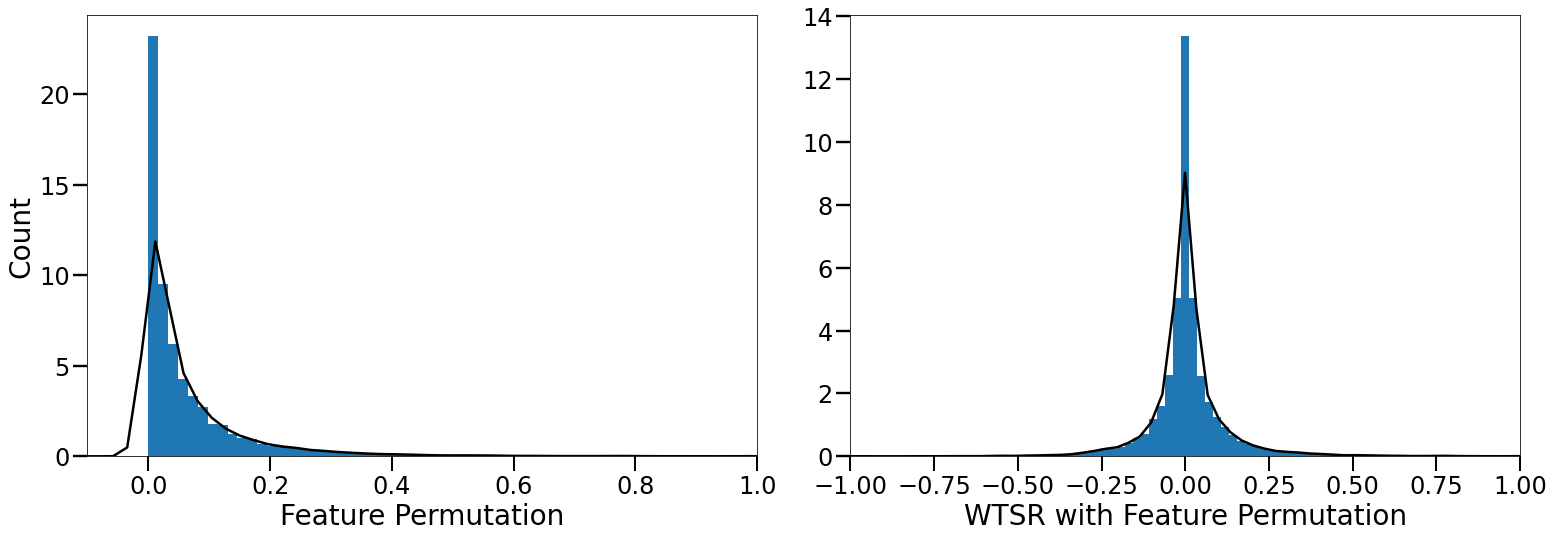

In [218]:
import scipy.stats as st
fig, axes = plt.subplots(1, 2, figsize=(22, 8))
n_bins = 128

dist1 = attr_numpy[:, output, :, 20].flatten()
dist2 = tsr_attr_numpy[:, output, :, 20].flatten()

_ = axes[0].hist(dist1, bins=n_bins, density=True)
# We can set the number of bins with the *bins* keyword argument.
kde = st.gaussian_kde(dist1)
mn, mx = axes[0].get_xlim()
kde_xs = np.linspace(mn, mx, 100)
axes[0].plot(kde_xs, kde.pdf(kde_xs), label="PDF", color='black')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Feature Permutation')
axes[0].set_xlim(-0.1, 1)

_ = axes[1].hist(dist2, bins=n_bins, density=True)
axes[1].set_xlabel('WTSR with Feature Permutation')
kde = st.gaussian_kde(dist2)
mn, mx = axes[1].get_xlim()
kde_xs = np.linspace(mn, mx, 100)
axes[1].plot(kde_xs, kde.pdf(kde_xs), label="PDF", color='black')
axes[1].set_xlim(-1, 1)
# plt.suptitle('Histogram and density plot of feature importance scores')
fig.tight_layout()
plt.savefig('results/density.jpg', dpi=200)